In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [16]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy/Texas - total electricity consumption - quarterly (short tons).csv')
df.head()

,Texas - electric power (total coal consumption) - quarterly,short tons
0,2001 Q1,22164839
1,2001 Q2,22952510
2,2001 Q3,25962808
3,2001 Q4,21357650
4,2002 Q1,21917084


In [17]:
df.tail()

,Texas - electric power (total coal consumption) - quarterly,short tons
75,2019 Q4,13866538
76,2020 Q1,11029285
77,2020 Q2,12950538
78,2020 Q3,17219614
79,2020 Q4,14869537


In [18]:
df.shape

(80, 2)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
 #   Column                                                        Non-Null Count  Dtype 
---  ------                                                        --------------  ----- 
 0   Texas - electric power (total coal consumption) - quarterly   80 non-null     object
 1    short tons                                                   80 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [20]:
df.isnull().sum()

Texas - electric power (total coal consumption) - quarterly     0
 short tons                                                     0
dtype: int64

In [21]:
time = pd.date_range(start='1/1/2001',periods=80,freq='Q')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Texas - electric power (total coal consumption) - quarterly '],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [22]:
len(time)

80

In [23]:
df.head()

,short tons
time_stamp,
2001-03-31,22164839
2001-06-30,22952510
2001-09-30,25962808
2001-12-31,21357650
2002-03-31,21917084


In [24]:
df.tail()

,short tons
time_stamp,
2019-12-31,13866538
2020-03-31,11029285
2020-06-30,12950538
2020-09-30,17219614
2020-12-31,14869537


In [25]:
df

,short tons
time_stamp,
2001-03-31,22164839
2001-06-30,22952510
2001-09-30,25962808
2001-12-31,21357650
2002-03-31,21917084
...,...
2019-12-31,13866538
2020-03-31,11029285
2020-06-30,12950538


In [26]:
plt.rcParams['figure.figsize'] = [15,8]

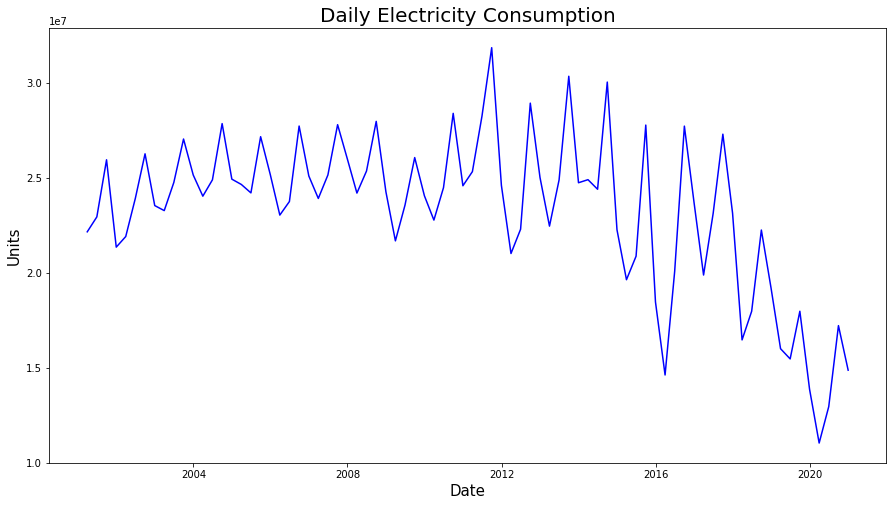

In [27]:
plt.plot(df,color='blue')
plt.title('Daily Electricity Consumption',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [28]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [68]:
#Split data set into testing dataset and train dataset
train_size = 68
train, test =df.values[0:train_size,:],df.values[train_size:len(df.values),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [69]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(64, 4)
(64,)
(8, 4)
(8,)


In [31]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.2 MB/s 


In [32]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [113]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 128,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [115]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=2,
    directory='project',
    project_name='texas_consum_3')

In [116]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [117]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=8,
             validation_data=(testX, testY))

Trial 20 Complete [00h 00m 20s]
val_mape: 9.424637794494629

Best val_mape So Far: 8.408699989318848
Total elapsed time: 00h 07m 46s
INFO:tensorflow:Oracle triggered exit


In [118]:
tuner.results_summary()

Results summary
Results in project/texas_consum_3
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 16
dropout: False
learning_rate: 0.007004173713426855
Dropout_rate: 0.4
units_1: 80
units_2: 64
units_3: 88
units_4: 48
Score: 8.408699989318848
Trial summary
Hyperparameters:
num_layers: 3
units_0: 32
dropout: True
learning_rate: 0.011642545552035942
Dropout_rate: 0.0
units_1: 120
units_2: 96
units_3: 64
units_4: 80
Score: 8.618100643157959
Trial summary
Hyperparameters:
num_layers: 3
units_0: 32
dropout: False
learning_rate: 0.0126526817441444
Dropout_rate: 0.30000000000000004
units_1: 64
units_2: 8
units_3: 48
units_4: 16
Score: 8.772626876831055
Trial summary
Hyperparameters:
num_layers: 4
units_0: 40
dropout: False
learning_rate: 0.033354971021203265
Dropout_rate: 0.4
units_1: 72
units_2: 80
units_3: 56
units_4: 32
Score: 8.932705402374268
Trial summary
Hyperparameters:
num_layers: 2
units_0: 96
dropout: True
lea

In [76]:
from warnings import filterwarnings
filterwarnings('ignore')

In [119]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 80)                1360      
                                                                 
 dense_2 (Dense)             (None, 1)                 81        
                                                                 
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________


In [41]:
from tensorflow.keras import optimizers

In [126]:
model = Sequential()
model.add(Dense(16,activation='relu',input_dim = 4))
model.add(Dropout(0.2))
model.add(Dense(80,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.002004173713426855)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 8, epochs = 300)

Epoch 1/300
8/8 [==============================] - 1s 37ms/step - loss: 65.3786 - mape: 65.3786 - val_loss: 38.1084 - val_mape: 38.1084
Epoch 2/300
8/8 [==============================] - 0s 7ms/step - loss: 33.9042 - mape: 33.9042 - val_loss: 15.9331 - val_mape: 15.9331
Epoch 3/300
8/8 [==============================] - 0s 7ms/step - loss: 33.2864 - mape: 33.2864 - val_loss: 21.3941 - val_mape: 21.3941
Epoch 4/300
8/8 [==============================] - 0s 6ms/step - loss: 25.9493 - mape: 25.9493 - val_loss: 14.8136 - val_mape: 14.8136
Epoch 5/300
8/8 [==============================] - 0s 7ms/step - loss: 25.3531 - mape: 25.3531 - val_loss: 13.9757 - val_mape: 13.9757
Epoch 6/300
8/8 [==============================] - 0s 6ms/step - loss: 21.4842 - mape: 21.4842 - val_loss: 14.7737 - val_mape: 14.7737
Epoch 7/300
8/8 [==============================] - 0s 7ms/step - loss: 19.4824 - mape: 19.4824 - val_loss: 12.8366 - val_mape: 12.8366
Epoch 8/300
8/8 [==============================] - 0s 

In [127]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train MAPE : %.2f  17.9104061126709
Test MAPE : %.2f  10.975639343261719


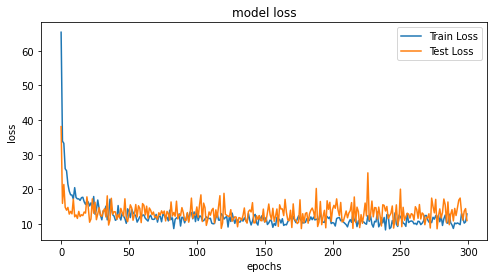

In [128]:
train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train MAPE : %.2f ',train_score[1])
test_score = model.evaluate(testX, testY, verbose=0)
print('Test MAPE : %.2f ',test_score[1])
model_loss(model_history)

In [65]:
import seaborn as sns

In [83]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(64,72)]
    plt.figure(figsize=(15,8))
    plt.plot(trainY)
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

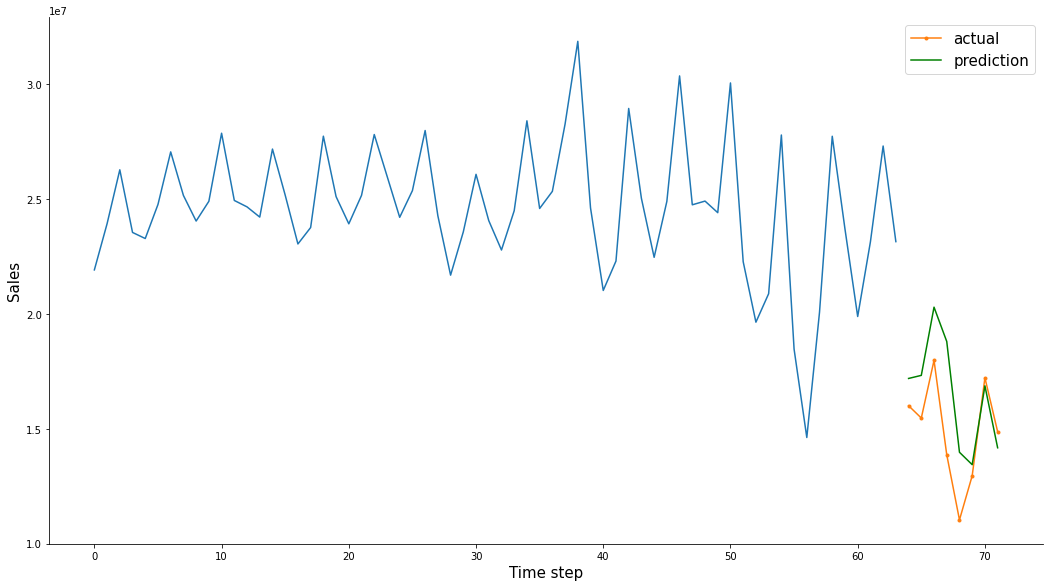

In [84]:
test_predict = model.predict(testX)
prediction_plot(testY, test_predict)